In [1]:
!wget http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes -O mm10.chrom.sizes 

--2020-06-12 00:01:35--  http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1405 (1.4K) [text/plain]
Saving to: ‘mm10.chrom.sizes’

mm10.chrom.sizes    100%[===================>]   1.37K  --.-KB/s    in 0s      

2020-06-12 00:01:35 (102 MB/s) - ‘mm10.chrom.sizes’ saved [1405/1405]



In [2]:
#get 1kb around summits
!zcat Oct4/idr-optimal-set.summit.bed.gz Sox2/idr-optimal-set.summit.bed.gz Nanog/idr-optimal-set.summit.bed.gz Klf4/idr-optimal-set.summit.bed.gz | perl -lane 'print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))' | bedtools slop -g mm10.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t1"}' | sortBed | gzip -c > 1k_around_summits.bed.gz
#split into train, valid, test sets
!zcat 1k_around_summits.bed.gz | egrep -w 'chr2|chr3|chr4' | gzip -c > test_1k_around_summits.bed.gz
!zcat 1k_around_summits.bed.gz | egrep -w 'chr1|chr8|chr9' | gzip -c > valid_1k_around_summits.bed.gz
!zcat 1k_around_summits.bed.gz | egrep -w -v 'chr1|chr2|chr3|chr4|chr9' | gzip -c > train_1k_around_summits.bed.gz

In [1]:
from collections import OrderedDict
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from seqdataloader.batchproducers.coordbased.coordstovals.core import CoordsToValsJoiner
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import AbstractCountAndProfileTransformer 
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import LogCountsPlusOne
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import SmoothProfiles
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import BigWigReader 
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import smooth_profiles
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import rolling_window
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import MultiTrackCountsAndProfile
import keras
import keras.layers as kl
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers.coordbased.core import Coordinates, KerasBatchGenerator, apply_mask
from keras.models import load_model
import os
from keras.utils import CustomObjectScope
from seqdataloader.batchproducers.coordbased.core import Coordinates

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#Written by Žiga Avsec
import pyBigWig

#loss function
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#Written by Žiga Avsec
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}
    
#poisson loss but we take the exponent of the
# labels to convert them from log(counts+1)
# to counts.
def exponentiate_label_poisson(true, preds):
    true_counts = tf.exp(true)-1
    return tf.keras.losses.poisson(y_true=true_counts,
                                   y_pred=preds)


def poisson_loglinear_loss(true, preds):
    true_counts = tf.exp(true)-1
    preds_counts = tf.exp(preds)
    return tf.keras.losses.poisson(y_true=true_counts,
                                   y_pred=preds_counts)

In [32]:
# If we want to avoid zero-padding, then the size of the output predictions
# will depend on the size of the input sequence supplied. We define the
# API for an AbstractProfileModel class which returns the length of the
# output profile in addition to returning the model, given information
# on the size of the input sequence and the model parameters.
        
class AbstractProfileModel(object):
    
    def get_output_profile_len(self):
        raise NotImplementedError()
  
    def get_model(self):
        raise NotImplementedError()

# The architecture by Žiga Avsec involves residual connections, which means
# that the layers being added together in an elementwise fashion need
# to have the same dimensions. To achieve this without zero-padding, we
# have to trim away the flanks of earlier convolutional layers. That
# is what this function is meant to do. (Note that the original BP-net
# architecture zero-pads; this is a modification to avoid the zero
# padding and use information on actual sequence instead)

def trim_flanks_of_conv_layer(conv_layer, output_len, width_to_trim, filters):
    layer = keras.layers.Lambda(
        lambda x: x[:,
          int(0.5*(width_to_trim)):-(width_to_trim-int(0.5*(width_to_trim)))],
        output_shape=(output_len, filters))(conv_layer)
    return layer


#This model architecture is based on BP-Net by Žiga Avsec
# https://drive.google.com/file/d/1kg6Ic0-FvJtVUva9Mh3FPnOAHJcN6VB-/view
#It has been modified for this specific use-case.
class BPnetArch(AbstractProfileModel):   

    def __init__(self, counts_loss,
                       log_space_preds,
                       input_seq_len, c_task_weight, filters,
                       n_dil_layers, conv1_kernel_size,
                       dil_kernel_size,
                       outconv_kernel_size, lr,
                       seed=1234):
        self.counts_loss = counts_loss
        self.log_space_preds = log_space_preds
        print("LOG SPACE PREDS IS SET TO",log_space_preds)
        self.input_seq_len = input_seq_len
        self.c_task_weight = c_task_weight
        self.filters = filters
        self.n_dil_layers = n_dil_layers
        self.conv1_kernel_size = conv1_kernel_size
        self.dil_kernel_size = dil_kernel_size
        self.outconv_kernel_size = outconv_kernel_size
        self.lr = lr
        self.seed = seed
    
    def get_embedding_len(self):
        embedding_len = self.input_seq_len
        embedding_len -= (self.conv1_kernel_size-1)     
        for i in range(1, self.n_dil_layers+1):
            dilation_rate = (2**i)
            embedding_len -= dilation_rate*(self.dil_kernel_size-1)
        return embedding_len
    
    def get_output_profile_len(self):
        embedding_len = self.get_embedding_len()
        out_profile_len = embedding_len - (self.outconv_kernel_size - 1)
        return out_profile_len
    
    def get_keras_model(self):
      
        np.random.seed(self.seed)
        tf.set_random_seed(self.seed)

        out_pred_len = self.get_output_profile_len()
        
        #'inp' is the one-hot encoded DNA sequence input
        inp = kl.Input(shape=(self.input_seq_len, 4), name='sequence')
        first_conv = kl.Conv1D(filters=self.filters,
                               kernel_size=self.conv1_kernel_size,
                               padding='valid',
                               activation='relu')(inp)
        
        #Need to keep track of the layer size for trimming purposes when
        # we get to the residual connections.
        
        curr_layer_size = self.input_seq_len - (self.conv1_kernel_size-1)
        
        #Define input layers for the control tracks - both counts and profile
        #Dimension is '1' for the ChIP-seq control counts because the positive
        # and negative strands are added together
        
        patchcap_logcount = kl.Input(
            shape=(2,), name="patchcap.logcount")
        #if working with raw counts, go from logcount->count
        if (self.log_space_preds):
            patchcap_count_touse = kl.Lambda(lambda x: tf.exp(x)-1)(patchcap_logcount) 
        else:
            patchcap_count_touse = patchcap_logcount
        
        patchcap_profile = kl.Input(
            shape=(out_pred_len, 2), name="patchcap.profile")
        
        #Gather together all the tensors representing the model inputs
        model_inputs = [
            inp,
            patchcap_logcount,
            patchcap_profile
        ]
        
        #Prepare the stack of dilated convolutions with residual connections
        prev_layer = first_conv
        for i in range(1, self.n_dil_layers + 1):
            dilation_rate = 2**i
            conv_output = kl.Conv1D(filters=self.filters,
                                  kernel_size=self.dil_kernel_size,
                                  padding='valid',
                                  activation='relu',
                                  dilation_rate=dilation_rate)(prev_layer)          
            width_to_trim = dilation_rate*(self.dil_kernel_size-1)
            curr_layer_size = (curr_layer_size - width_to_trim)
            prev_layer = trim_flanks_of_conv_layer(
              conv_layer=prev_layer, output_len=curr_layer_size,
              width_to_trim=width_to_trim, filters=self.filters)
            prev_layer = kl.merge.Add()([prev_layer, conv_output])

        combined_conv = prev_layer

        #gap = GlobalAveragePooling. This layer is used as input for the
        # counts prediction tasks.
        gap_combined_conv = kl.GlobalAvgPool1D()(combined_conv)
        
        lossarr = []
        lossweightsarr = []
        model_outputs = []
    
        #Define the output layers for the counts prediction tasks
        for countouttaskname, numunits, countcontrolinp in [("CHIPNexus.NANOG.logcount", 2, patchcap_count_touse),
                                                            ("CHIPNexus.OCT4.logcount", 2, patchcap_count_touse),
                                                            ("CHIPNexus.KLF4.logcount", 2, patchcap_count_touse),
                                                            ("CHIPNexus.SOX2.logcount", 2, patchcap_count_touse)]:
            count_out = kl.Dense(
                units=numunits,
                name=countouttaskname,
                activation=("linear" if self.counts_loss=="mse" else "softplus"))(
                    kl.concatenate([gap_combined_conv, countcontrolinp], axis=-1))
            model_outputs.append(count_out)
            lossarr.append(self.counts_loss)
            lossweightsarr.append(self.c_task_weight)

        #Define the output layers for the profile prediction tasks
        for profileouttaskname, numunits, profilecontrolinp in [("CHIPNexus.NANOG.profile", 2, patchcap_profile),
                                                                ("CHIPNexus.OCT4.profile", 2, patchcap_profile),
                                                                ("CHIPNexus.KLF4.profile", 2, patchcap_profile),
                                                                ("CHIPNexus.SOX2.profile", 2, patchcap_profile)]:
                                                                
        
            profile_out_precontrol = kl.Conv1D(
                                      filters=numunits,
                                      kernel_size=self.outconv_kernel_size,
                                      padding='valid')(combined_conv)
            profile_out = kl.Conv1D(filters=numunits, kernel_size=1, name=profileouttaskname)(kl.concatenate([profile_out_precontrol,profilecontrolinp], axis=-1))

            model_outputs.append(profile_out)
            lossarr.append(MultichannelMultinomialNLL(numunits)) 
              #We downweight the loss by the number of channels because, if you
              # read the code for MultichannelMultinomialNLL, you'll see that
              # the loss for different channels is added together;
              # but I (Avanti Shrikumar) didn't want to implicitly upweight
              # the prediction tasks that happen
              # to have more channels, hence this downweighting.
            lossweightsarr.append(1.0/numunits)

        #Compile the model and return it
        model = keras.models.Model(inputs=model_inputs, outputs=model_outputs)
        model.compile(keras.optimizers.Adam(lr=self.lr),
                      loss=lossarr,
                      loss_weights=lossweightsarr)
        return model

# the code below is used to prepare instances of keras.utils.Sequence that
# can be supplied to model.fit_generator(...)
# Note that we log-transform our counts using np.log(counts+1)
# Also note that the profiles for the control are smoothed by windows of
# size 1 and 50 (smoothing by a window of size 1 just returns
# the original profile)

inputs_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
        genome_fasta_path="mm10_no_alt_analysis_set_ENCODE.fasta",
        mode_name="sequence",
        center_size_to_use=seq_len),
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="patchcap.logcount",
        profile_mode_name="patchcap.profile",
        pos_strand_bigwig_path="patchcap/counts.pos.bw",
        neg_strand_bigwig_path="patchcap/counts.neg.bw",
        center_size_to_use=out_pred_len),
    ]
)
    

targets_coordstovals = CoordsToValsJoiner(
    coordstovals_list=[
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="CHIPNexus.NANOG.logcount",
        profile_mode_name="CHIPNexus.NANOG.profile",
        pos_strand_bigwig_path="Nanog/counts.pos.bw",
        neg_strand_bigwig_path="Nanog/counts.neg.bw",
        center_size_to_use=out_pred_len),
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="CHIPNexus.OCT4.logcount",
        profile_mode_name="CHIPNexus.OCT4.profile",
        pos_strand_bigwig_path="Oct4/counts.pos.bw",
        neg_strand_bigwig_path="Oct4/counts.neg.bw",
        center_size_to_use=out_pred_len),
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="CHIPNexus.KLF4.logcount",
        profile_mode_name="CHIPNexus.KLF4.profile",
        pos_strand_bigwig_path="Klf4/counts.pos.bw",
        neg_strand_bigwig_path="Klf4/counts.neg.bw",
        center_size_to_use=out_pred_len),
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="CHIPNexus.SOX2.logcount",
        profile_mode_name="CHIPNexus.SOX2.profile",
        pos_strand_bigwig_path="Sox2/counts.pos.bw",
        neg_strand_bigwig_path="Sox2/counts.neg.bw",
        center_size_to_use=out_pred_len),
    ]
)

keras_train_batch_generator = KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
      bed_file="train_1k_around_summits.bed.gz",
      batch_size=64,
      shuffle_before_epoch=True, 
      seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals,
  coordsbatch_transformer=
          coordbatchtransformers.ReverseComplementAugmenter().chain(
          coordbatchtransformers.UniformJitter(
              maxshift=200, chromsizes_file="mm10.chrom.sizes")),
)

keras_valid_batch_generator = KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="valid_1k_around_summits.bed.gz",
            batch_size=64,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals
)

#As a sanity check, print out the dimensions of everything in individual batches
sampinputs,samptargets = keras_train_batch_generator[0]
# for key in sampinputs:
#   print(key, sampinputs[key].shape)
for key in samptargets:
    print(key, samptargets[key].shape)

Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
CHIPNexus.NANOG.logcount (128, 2)
CHIPNexus.NANOG.profile (128, 1000, 2)
CHIPNexus.OCT4.logcount (128, 2)
CHIPNexus.OCT4.profile (128, 1000, 2)
CHIPNexus.KLF4.logcount (128, 2)
CHIPNexus.KLF4.profile (128, 1000, 2)
CHIPNexus.SOX2.logcount (128, 2)
CHIPNexus.SOX2.profile (128, 1000, 2)


In [45]:
def extend_generator(generator):
    samp_inputs, samp_targets = generator[0]
    concat_inputs = OrderedDict([(key, []) for key in samp_inputs.keys()])
    concat_targets = OrderedDict([(key, []) for key in samp_targets.keys()])

    for batch_idx in range(len(generator)):
        batch_inputs, batch_targets = generator[batch_idx]
        for key in batch_inputs:
            concat_inputs[key].extend(batch_inputs[key])
        for key in batch_targets:
            concat_targets[key].extend(batch_targets[key])
    
    for key in concat_inputs:
        concat_inputs[key] = np.array(concat_inputs[key])
    
    for key in concat_targets:
        concat_targets[key] = np.array(concat_targets[key])
    
    return (concat_inputs, concat_targets)

from scipy.stats import spearmanr
from matplotlib import pyplot as plt

def plot_scatter(preds, targets, keys, takelogofpreds):
    fig, ax = plt.subplots(nrows=1, ncols=len(keys),
                           figsize=(5*len(keys),5))
    for i,key in enumerate(keys):
        if takelogofpreds:
            x = np.sum(np.log(preds[key]+1), axis=-1)
        else:
            x = np.sum(preds[key], axis=-1)
        y = np.sum(targets[key], axis=-1)
        ax[i].scatter(x, y, alpha=0.01)        
        ax[i].set_xlabel("Preds: "+key)
        ax[i].set_ylabel("Targets: "+key)
        ax[i].plot(x, x, color='black')
        print(key,spearmanr(x,y))
    plt.show()

In [42]:
#get the unrolled validation set
valid_concat_inputs, valid_concat_targets = extend_generator(keras_valid_batch_generator)

1000 346
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 1346, 4)      0                                            
__________________________________________________________________________________________________
conv1d_144 (Conv1D)             (None, 1326, 64)     5440        sequence[0][0]                   
__________________________________________________________________________________________________
lambda_83 (Lambda)              (None, 1322, 64)     0           conv1d_144[0][0]                 
__________________________________________________________________________________________________
conv1d_145 (Conv1D)             (None, 1322, 64)     12352       conv1d_144[0][0]                 
__________________________________________________________________________________

Epoch 1/200
Scatterplots before epoch 0
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=-0.2635552373145125, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=-0.1712351742149185, pvalue=1.9026549106530637e-181)
CHIPNexus.NANOG.logcount SpearmanrResult(correlation=0.0810940939472331, pvalue=1.1135368450230463e-41)
CHIPNexus.KLF4.logcount SpearmanrResult(correlation=0.0183054819752336, pvalue=0.002301846153525783)


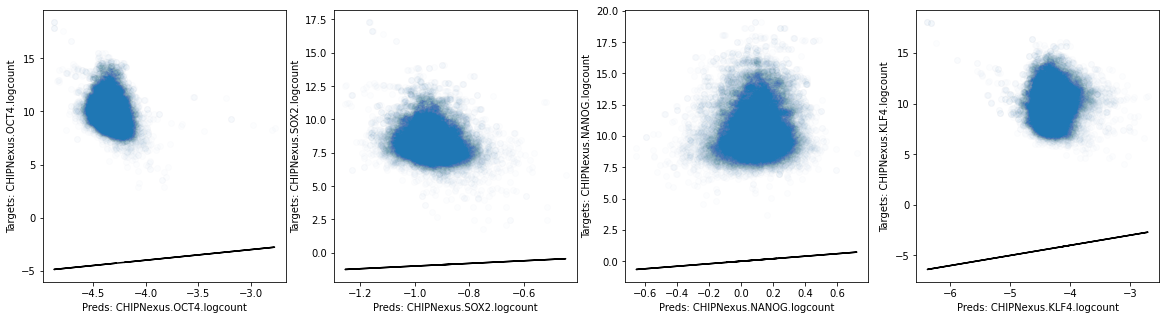

1614/1614 [==============================] - 729s 452ms/step - loss: 3480.4302 - CHIPNexus.NANOG.logcount_loss: 0.9293 - CHIPNexus.OCT4.logcount_loss: 0.6271 - CHIPNexus.KLF4.logcount_loss: 0.7714 - CHIPNexus.SOX2.logcount_loss: 0.3884 - CHIPNexus.NANOG.profile_loss: 1482.0144 - CHIPNexus.OCT4.profile_loss: 1165.4059 - CHIPNexus.KLF4.profile_loss: 1021.4437 - CHIPNexus.SOX2.profile_loss: 575.8455 - val_loss: 2231.0715 - val_CHIPNexus.NANOG.logcount_loss: 0.7663 - val_CHIPNexus.OCT4.logcount_loss: 0.4364 - val_CHIPNexus.KLF4.logcount_loss: 0.6383 - val_CHIPNexus.SOX2.logcount_loss: 0.2967 - val_CHIPNexus.NANOG.profile_loss: 1320.1924 - val_CHIPNexus.OCT4.profile_loss: 1071.1722 - val_CHIPNexus.KLF4.profile_loss: 1016.1412 - val_CHIPNexus.SOX2.profile_loss: 531.0112
Epoch 2/200
Scatterplots before epoch 1
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.3249074400825023, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.3905761354822701, pvalue=0.0)
CHIPNexus.NANOG.l

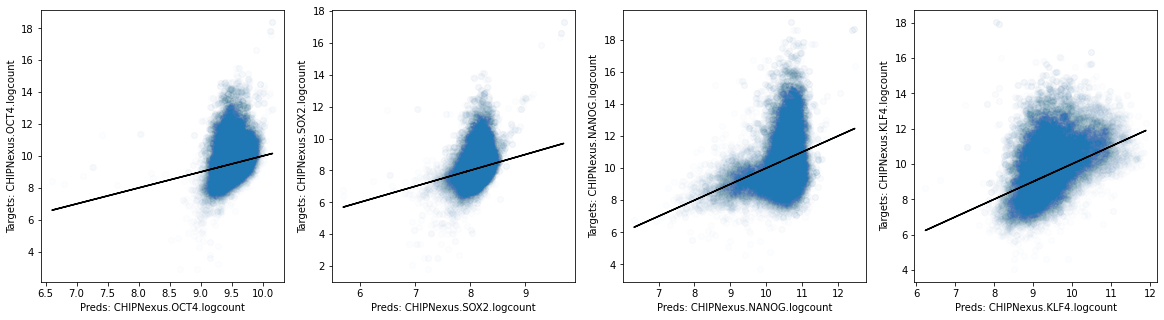

1614/1614 [==============================] - 727s 450ms/step - loss: 2963.7821 - CHIPNexus.NANOG.logcount_loss: 0.7851 - CHIPNexus.OCT4.logcount_loss: 0.4164 - CHIPNexus.KLF4.logcount_loss: 0.5389 - CHIPNexus.SOX2.logcount_loss: 0.2887 - CHIPNexus.NANOG.profile_loss: 1308.0399 - CHIPNexus.OCT4.profile_loss: 1078.6090 - CHIPNexus.KLF4.profile_loss: 976.6566 - CHIPNexus.SOX2.profile_loss: 535.2042 - val_loss: 2050.8650 - val_CHIPNexus.NANOG.logcount_loss: 0.7194 - val_CHIPNexus.OCT4.logcount_loss: 0.3597 - val_CHIPNexus.KLF4.logcount_loss: 0.5240 - val_CHIPNexus.SOX2.logcount_loss: 0.2625 - val_CHIPNexus.NANOG.profile_loss: 1218.1802 - val_CHIPNexus.OCT4.profile_loss: 1018.0583 - val_CHIPNexus.KLF4.profile_loss: 991.9267 - val_CHIPNexus.SOX2.profile_loss: 515.8104
Epoch 3/200
Scatterplots before epoch 2
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.4320583709052398, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.453699941777112, pvalue=0.0)
CHIPNexus.NANOG.logc

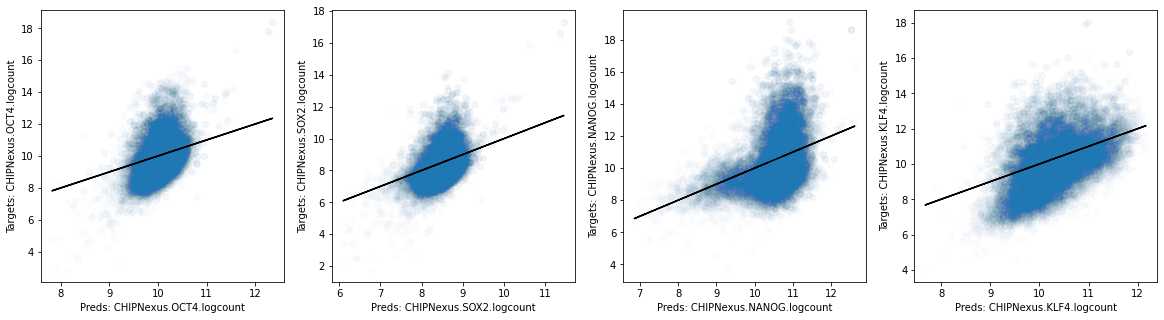

1614/1614 [==============================] - 717s 444ms/step - loss: 2769.4398 - CHIPNexus.NANOG.logcount_loss: 0.7211 - CHIPNexus.OCT4.logcount_loss: 0.3604 - CHIPNexus.KLF4.logcount_loss: 0.4945 - CHIPNexus.SOX2.logcount_loss: 0.2490 - CHIPNexus.NANOG.profile_loss: 1235.0594 - CHIPNexus.OCT4.profile_loss: 1018.2231 - CHIPNexus.KLF4.profile_loss: 956.7394 - CHIPNexus.SOX2.profile_loss: 503.8388 - val_loss: 2086.4612 - val_CHIPNexus.NANOG.logcount_loss: 0.7557 - val_CHIPNexus.OCT4.logcount_loss: 0.3501 - val_CHIPNexus.KLF4.logcount_loss: 0.5446 - val_CHIPNexus.SOX2.logcount_loss: 0.2524 - val_CHIPNexus.NANOG.profile_loss: 1200.6885 - val_CHIPNexus.OCT4.profile_loss: 980.3488 - val_CHIPNexus.KLF4.profile_loss: 974.4613 - val_CHIPNexus.SOX2.profile_loss: 507.8815
Epoch 4/200
Scatterplots before epoch 3
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.5228488148278928, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.5503616853706589, pvalue=0.0)
CHIPNexus.NANOG.logc

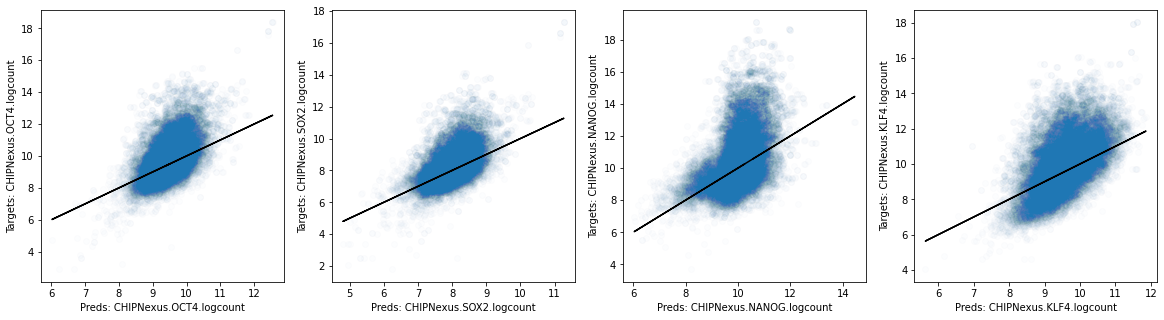

1614/1614 [==============================] - 721s 447ms/step - loss: 2645.1543 - CHIPNexus.NANOG.logcount_loss: 0.6826 - CHIPNexus.OCT4.logcount_loss: 0.3249 - CHIPNexus.KLF4.logcount_loss: 0.4767 - CHIPNexus.SOX2.logcount_loss: 0.2260 - CHIPNexus.NANOG.profile_loss: 1180.9281 - CHIPNexus.OCT4.profile_loss: 979.1138 - CHIPNexus.KLF4.profile_loss: 939.0410 - CHIPNexus.SOX2.profile_loss: 481.0599 - val_loss: 1995.6157 - val_CHIPNexus.NANOG.logcount_loss: 0.6486 - val_CHIPNexus.OCT4.logcount_loss: 0.2807 - val_CHIPNexus.KLF4.logcount_loss: 0.4706 - val_CHIPNexus.SOX2.logcount_loss: 0.2112 - val_CHIPNexus.NANOG.profile_loss: 1162.2080 - val_CHIPNexus.OCT4.profile_loss: 947.0576 - val_CHIPNexus.KLF4.profile_loss: 955.7376 - val_CHIPNexus.SOX2.profile_loss: 499.6191
Epoch 5/200
Scatterplots before epoch 4
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.5640126729540146, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.5819245364453339, pvalue=0.0)
CHIPNexus.NANOG.logco

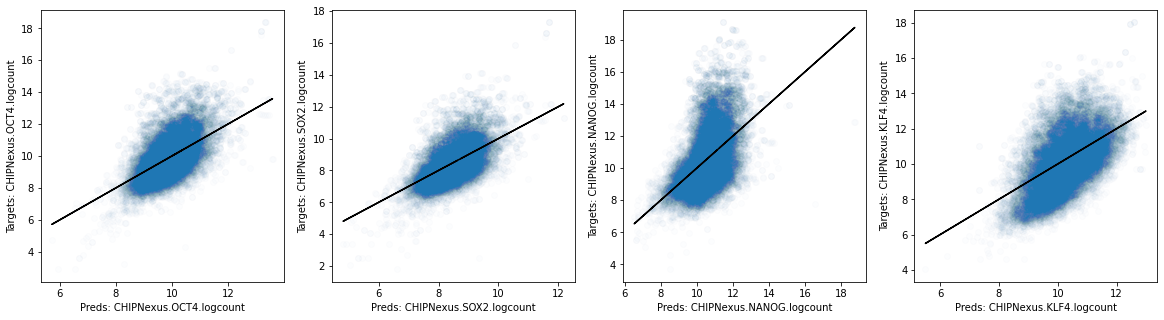

1614/1614 [==============================] - 725s 449ms/step - loss: 2553.2507 - CHIPNexus.NANOG.logcount_loss: 0.6530 - CHIPNexus.OCT4.logcount_loss: 0.3035 - CHIPNexus.KLF4.logcount_loss: 0.4561 - CHIPNexus.SOX2.logcount_loss: 0.2139 - CHIPNexus.NANOG.profile_loss: 1143.2650 - CHIPNexus.OCT4.profile_loss: 944.4781 - CHIPNexus.KLF4.profile_loss: 922.8780 - CHIPNexus.SOX2.profile_loss: 469.3773 - val_loss: 1880.5194 - val_CHIPNexus.NANOG.logcount_loss: 0.6897 - val_CHIPNexus.OCT4.logcount_loss: 0.2684 - val_CHIPNexus.KLF4.logcount_loss: 0.4507 - val_CHIPNexus.SOX2.logcount_loss: 0.2122 - val_CHIPNexus.NANOG.profile_loss: 1134.7087 - val_CHIPNexus.OCT4.profile_loss: 921.2365 - val_CHIPNexus.KLF4.profile_loss: 951.7527 - val_CHIPNexus.SOX2.profile_loss: 494.4321
Epoch 6/200
Scatterplots before epoch 5
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.5914773053606716, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6016520135020623, pvalue=0.0)
CHIPNexus.NANOG.logco

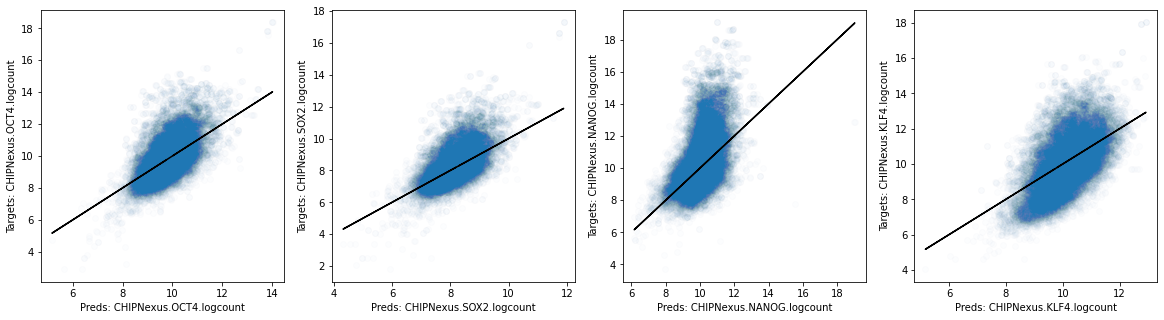

1614/1614 [==============================] - 717s 444ms/step - loss: 2525.8318 - CHIPNexus.NANOG.logcount_loss: 0.6547 - CHIPNexus.OCT4.logcount_loss: 0.3174 - CHIPNexus.KLF4.logcount_loss: 0.4512 - CHIPNexus.SOX2.logcount_loss: 0.2224 - CHIPNexus.NANOG.profile_loss: 1115.9469 - CHIPNexus.OCT4.profile_loss: 908.3398 - CHIPNexus.KLF4.profile_loss: 916.0110 - CHIPNexus.SOX2.profile_loss: 465.6983 - val_loss: 2011.2939 - val_CHIPNexus.NANOG.logcount_loss: 0.6235 - val_CHIPNexus.OCT4.logcount_loss: 0.2778 - val_CHIPNexus.KLF4.logcount_loss: 0.4936 - val_CHIPNexus.SOX2.logcount_loss: 0.2047 - val_CHIPNexus.NANOG.profile_loss: 1117.0441 - val_CHIPNexus.OCT4.profile_loss: 899.9140 - val_CHIPNexus.KLF4.profile_loss: 948.2320 - val_CHIPNexus.SOX2.profile_loss: 491.7032
Epoch 7/200
Scatterplots before epoch 6
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.5929200884674484, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.5987807952751613, pvalue=0.0)
CHIPNexus.NANOG.logco

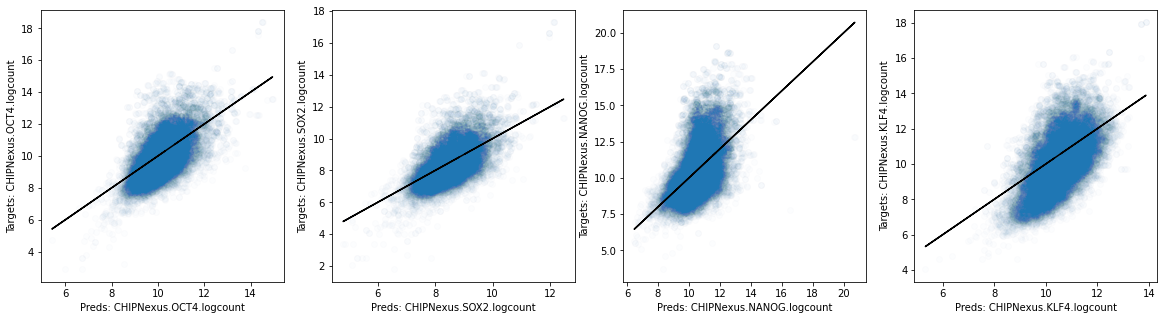

1614/1614 [==============================] - 723s 448ms/step - loss: 2444.6522 - CHIPNexus.NANOG.logcount_loss: 0.6195 - CHIPNexus.OCT4.logcount_loss: 0.2832 - CHIPNexus.KLF4.logcount_loss: 0.4333 - CHIPNexus.SOX2.logcount_loss: 0.2043 - CHIPNexus.NANOG.profile_loss: 1085.3569 - CHIPNexus.OCT4.profile_loss: 889.4780 - CHIPNexus.KLF4.profile_loss: 913.2101 - CHIPNexus.SOX2.profile_loss: 460.9403 - val_loss: 2046.9706 - val_CHIPNexus.NANOG.logcount_loss: 0.6583 - val_CHIPNexus.OCT4.logcount_loss: 0.2598 - val_CHIPNexus.KLF4.logcount_loss: 0.4300 - val_CHIPNexus.SOX2.logcount_loss: 0.1995 - val_CHIPNexus.NANOG.profile_loss: 1122.7283 - val_CHIPNexus.OCT4.profile_loss: 884.9165 - val_CHIPNexus.KLF4.profile_loss: 947.8071 - val_CHIPNexus.SOX2.profile_loss: 490.7050
Epoch 8/200
Scatterplots before epoch 7
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.607184150424434, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6125754581053591, pvalue=0.0)
CHIPNexus.NANOG.logcou

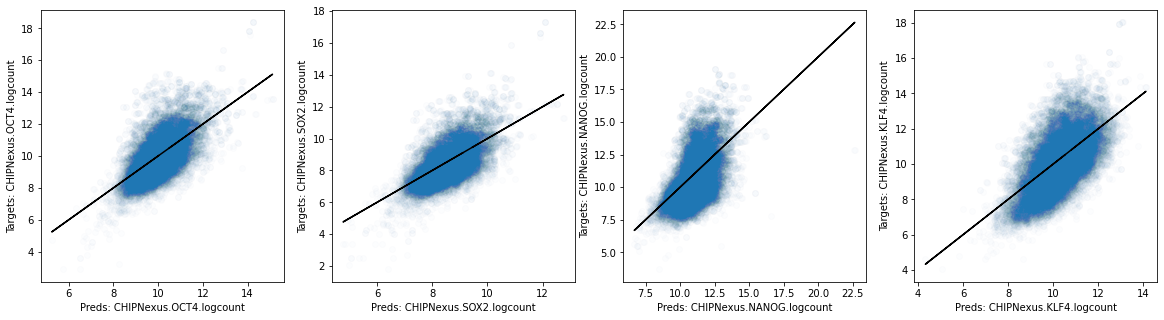

1614/1614 [==============================] - 718s 445ms/step - loss: 2389.3820 - CHIPNexus.NANOG.logcount_loss: 0.5991 - CHIPNexus.OCT4.logcount_loss: 0.2720 - CHIPNexus.KLF4.logcount_loss: 0.4143 - CHIPNexus.SOX2.logcount_loss: 0.1970 - CHIPNexus.NANOG.profile_loss: 1060.5526 - CHIPNexus.OCT4.profile_loss: 866.2024 - CHIPNexus.KLF4.profile_loss: 910.5997 - CHIPNexus.SOX2.profile_loss: 459.1112 - val_loss: 1857.3555 - val_CHIPNexus.NANOG.logcount_loss: 0.6228 - val_CHIPNexus.OCT4.logcount_loss: 0.2740 - val_CHIPNexus.KLF4.logcount_loss: 0.4558 - val_CHIPNexus.SOX2.logcount_loss: 0.2176 - val_CHIPNexus.NANOG.profile_loss: 1120.6224 - val_CHIPNexus.OCT4.profile_loss: 869.3301 - val_CHIPNexus.KLF4.profile_loss: 944.2634 - val_CHIPNexus.SOX2.profile_loss: 491.8609
Epoch 9/200
Scatterplots before epoch 8
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6222353721942326, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6185330150301209, pvalue=0.0)
CHIPNexus.NANOG.logco

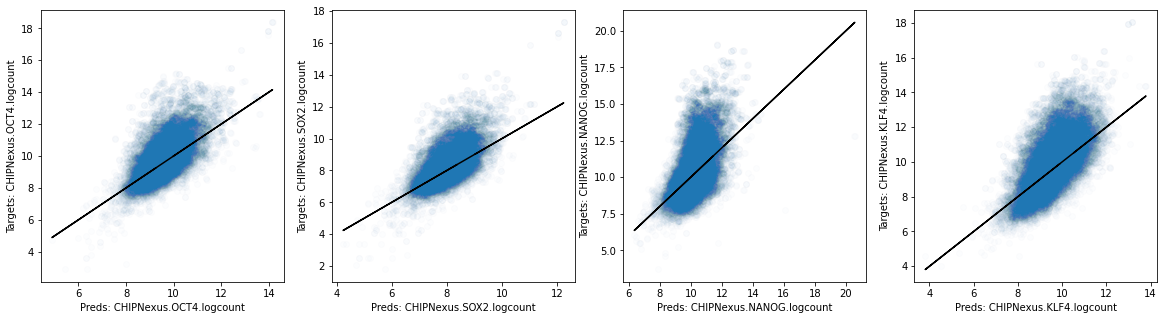

1614/1614 [==============================] - 724s 449ms/step - loss: 2350.0083 - CHIPNexus.NANOG.logcount_loss: 0.5828 - CHIPNexus.OCT4.logcount_loss: 0.2635 - CHIPNexus.KLF4.logcount_loss: 0.4011 - CHIPNexus.SOX2.logcount_loss: 0.1920 - CHIPNexus.NANOG.profile_loss: 1052.5797 - CHIPNexus.OCT4.profile_loss: 841.2413 - CHIPNexus.KLF4.profile_loss: 907.0477 - CHIPNexus.SOX2.profile_loss: 459.7147 - val_loss: 1869.2036 - val_CHIPNexus.NANOG.logcount_loss: 0.5946 - val_CHIPNexus.OCT4.logcount_loss: 0.2491 - val_CHIPNexus.KLF4.logcount_loss: 0.4045 - val_CHIPNexus.SOX2.logcount_loss: 0.1919 - val_CHIPNexus.NANOG.profile_loss: 1113.0259 - val_CHIPNexus.OCT4.profile_loss: 861.9983 - val_CHIPNexus.KLF4.profile_loss: 941.9240 - val_CHIPNexus.SOX2.profile_loss: 490.9901
Epoch 10/200
Scatterplots before epoch 9
CHIPNexus.OCT4.logcount SpearmanrResult(correlation=0.6240917384122356, pvalue=0.0)
CHIPNexus.SOX2.logcount SpearmanrResult(correlation=0.6137599511708257, pvalue=0.0)
CHIPNexus.NANOG.logc

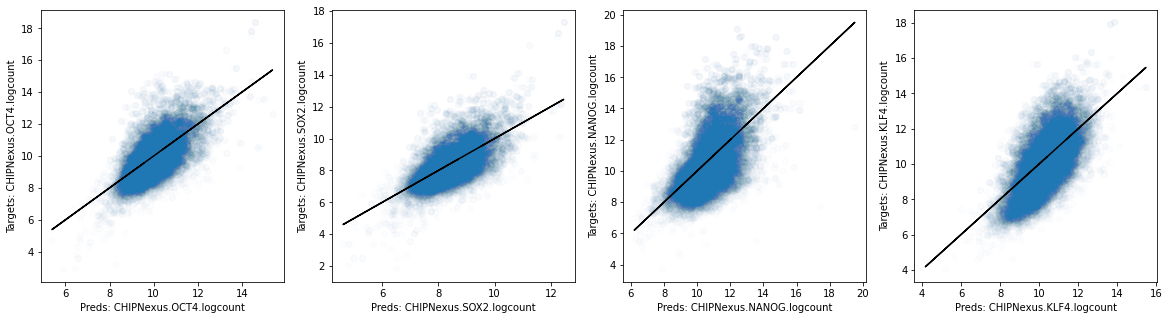

 178/1614 [==>...........................] - ETA: 10:33 - loss: 2324.2359 - CHIPNexus.NANOG.logcount_loss: 0.5766 - CHIPNexus.OCT4.logcount_loss: 0.2583 - CHIPNexus.KLF4.logcount_loss: 0.3787 - CHIPNexus.SOX2.logcount_loss: 0.1853 - CHIPNexus.NANOG.profile_loss: 1045.9874 - CHIPNexus.OCT4.profile_loss: 840.6290 - CHIPNexus.KLF4.profile_loss: 904.4127 - CHIPNexus.SOX2.profile_loss: 458.5493

KeyboardInterrupt: 

In [48]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

seq_len = 1346
counts_loss, log_space_preds, c_task_weight = ("mse", True, 500)
modelwrapper = BPnetArch(
    counts_loss=counts_loss,
    log_space_preds=log_space_preds,
    input_seq_len=seq_len,
    c_task_weight=c_task_weight,
    filters=64, n_dil_layers=6,
    conv1_kernel_size=21,
    dil_kernel_size=3,
    outconv_kernel_size=75,
    lr=0.001)
out_pred_len = modelwrapper.get_output_profile_len()
print(out_pred_len, seq_len-out_pred_len)

class PlotScatter(keras.callbacks.Callback):
    
    def __init__(self, takelogofpreds):
        self.takelogofpreds = takelogofpreds
    
    def on_epoch_begin(self, epoch, logs=None):
        print("Scatterplots before epoch",epoch)
        valid_preds = dict(zip(model.output_names, model.predict(valid_concat_inputs)))
        plot_scatter(preds=valid_preds, targets=valid_concat_targets,
                     takelogofpreds=self.takelogofpreds,
                     keys=['CHIPNexus.OCT4.logcount', 'CHIPNexus.SOX2.logcount',
                           'CHIPNexus.NANOG.logcount', 'CHIPNexus.KLF4.logcount'])

model = modelwrapper.get_keras_model()
print(model.summary())
early_stopping_callback = keras.callbacks.EarlyStopping(
                            patience=10, restore_best_weights=True)
loss_history = model.fit_generator(
                    keras_train_batch_generator,
                    epochs=200,
                    validation_data=keras_valid_batch_generator,
                    callbacks=[early_stopping_callback,
                               PlotScatter(takelogofpreds=(counts_loss not in log_space_preds))],
                    workers=1)
model.set_weights(early_stopping_callback.best_weights)